In [2]:
import os
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
dir_root = os.path.join('GOPRO_Large_all', 'train')
dir_list = [os.path.join(dir_root, p) for p in os.listdir(dir_root)]

In [4]:
import time

### Visualization

In [4]:
for d in dir_list:
    # image paths
    img_paths = [os.path.join(d, p) for p in os.listdir(d)]

    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))

    # Take first frame and find corners in it
    old_frame = cv.imread(img_paths[0])
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    wait = False
    for img_path in img_paths[1:256]:
        frame = cv.imread(img_path)
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
        # draw the tracks
        point_pairs = list(zip(good_new, good_old))
        for i, (new, old) in enumerate(point_pairs):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        img = cv.add(frame, mask)
        cv.imshow('frame', img)
        if not wait:
            time.sleep(5)
            wait = True
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    cv.destroyAllWindows()

### Point Distance Calculation

distance:  24.2976686535884


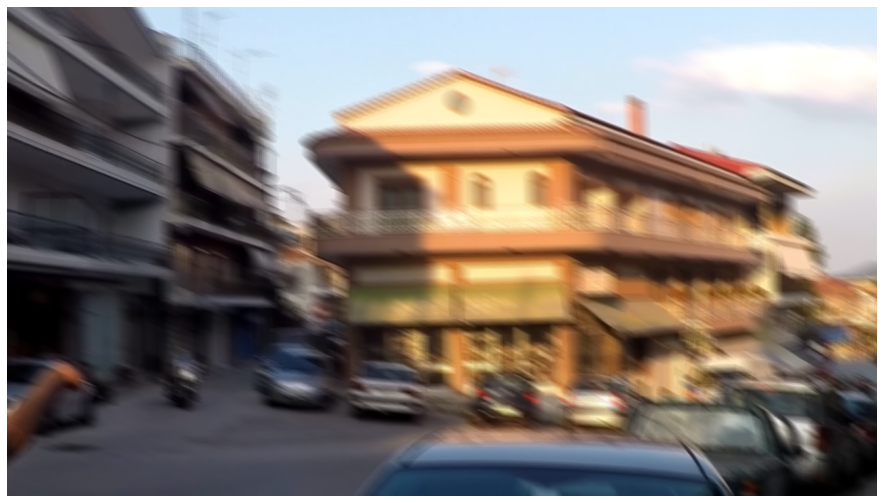

In [13]:
for d in dir_list:
    # image paths
    img_paths = [os.path.join(d, p) for p in os.listdir(d)]

    # frames
    frames = []

    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Take first frame and find corners in it
    old_frame = cv.imread(img_paths[0])
    frames.append(cv.cvtColor(old_frame, cv.COLOR_BGR2RGB))
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # total moving distance
    total_dist = 0

    for img_path in img_paths[1:9]:
        frame = cv.imread(img_path)
        frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
        # calculate distance between frames
        point_pairs = list(zip(good_new, good_old))
        dist = list(map(lambda x: math.sqrt(abs(x[0][0] - x[1][0]) ** 2 + abs(x[0][1] - x[1][1]) ** 2), point_pairs))
        avg_dist = sum(dist) / len(dist)
        total_dist += avg_dist
        # update old frame
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    
    print('distance: ', total_dist)

    mean = np.sum(np.array(frames), axis=0) / len(frames)
    mean = np.array(np.round(mean), dtype=np.uint8)
    plt.figure(figsize=(16, 9))
    plt.imshow(mean)
    plt.axis('off')
    plt.show()
    break